In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

In [2]:
df_aaindex = pd.read_csv('../data/aaindex/df_aaindex19.csv')
print(df_aaindex.shape)
df_aaindex.head(1)
tmp = df_aaindex.drop('Unnamed: 0',axis=1).T
aa2val = dict()
for aa, val in zip(tmp.index, tmp.values):
    aa2val[aa]=val

(19, 21)


In [3]:
df_detect_peptide_train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
test = test.loc[test.ID==1].reset_index(drop=True)
train, val = train_test_split(df_detect_peptide_train, test_size=0.2, random_state=7)

In [7]:
def get_data_labelEnc(df):
    label_enc = {v:k+1 for k, v in enumerate('ARNDCQEGHILKMFPSTWYV')}
    label_enc['Z']=0
    aa_data = [np.array([seq.count(a) for a in 'ARNDCQEGHILKMFPSTWYV'] + list(np.array([aa2val[aa] for aa in seq]).sum(axis=0)))
               for seq in df.PEP.values]
    pep_data = [[label_enc[aa] for aa in seq] + [0]*(30-len(seq))
               for seq in df.PEP.values]
    en_data = [[label_enc[aa] for aa in seq]
               for seq in df.En.values]
    ec_data = [[label_enc[aa] for aa in seq]
               for seq in df.Ec.values]
    e1_data = [[label_enc[aa] for aa in seq]
               if seq != '-' else [0 for _ in range(31)]
               for seq in df.E1.values]
    e2_data = [[label_enc[aa] for aa in seq]
               if seq != '-' else [0 for _ in range(31)]
               for seq in df.E2.values]
    return np.array(aa_data), np.array(pep_data), np.array(en_data), np.array(ec_data), np.array(e1_data), np.array(e2_data), np.array(df.ID.values)

In [5]:
label_enc = {v:k+1 for k, v in enumerate('ARNDCQEGHILKMFPSTWYV')}
print(label_enc)

{'A': 1, 'R': 2, 'N': 3, 'D': 4, 'C': 5, 'Q': 6, 'E': 7, 'G': 8, 'H': 9, 'I': 10, 'L': 11, 'K': 12, 'M': 13, 'F': 14, 'P': 15, 'S': 16, 'T': 17, 'W': 18, 'Y': 19, 'V': 20}


In [8]:
aa_test, pep_test, en_test, ec_test, e1_test, e2_test, y_test = get_data_labelEnc(test)
print(aa_test.shape, pep_test.shape, en_test.shape, ec_test.shape, e1_test.shape, e2_test.shape, y_test.shape)

(67100, 39) (67100, 30) (67100, 31) (67100, 31) (67100, 31) (67100, 31) (67100,)


# Train

In [9]:
from tensorflow.python.client import device_lib

import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024*2)])
    except RuntimeError as e:
        print(e)

In [10]:
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])

# high param

In [11]:
from tensorflow import keras

In [13]:
model_high_re = tf.keras.models.load_model("2021KSBi_multi_lr0005")

In [14]:
model_high_re.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 30)]         0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 31)]         0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 31)]         0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            [(None, 31)]         0                                            
______________________________________________________________________________________________

In [15]:
pep_output = 'dense_5'
n_output = 'dense_1'
c_output = 'dense_2'
m1_output = 'dense_3'
m2_output = 'dense_4'
intermediate_layer_model = keras.Model(inputs=model_high_re.input,
                                       outputs=[model_high_re.get_layer(pep_output).output,
                                                model_high_re.get_layer(n_output).output,
                                                model_high_re.get_layer(c_output).output,
                                                model_high_re.get_layer(m1_output).output,
                                                model_high_re.get_layer(m2_output).output])

In [16]:
intermediate_layer_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 30)]         0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 31)]         0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 31)]         0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            [(None, 31)]         0                                            
______________________________________________________________________________________________

In [17]:
pep_out, n_out, c_out, m1_out, m2_out = intermediate_layer_model.predict(
    [pep_test, aa_test, en_test, ec_test, e1_test, e2_test])

In [19]:
en = pd.DataFrame([[ts, 1] for ts in test.En.values], columns=['mers', 'label'])
ec = pd.DataFrame([[ts, 1] for ts in test.Ec.values], columns=['mers', 'label'])
e1 = pd.DataFrame([[ts, 0] for ts in test.E1.values], columns=['mers', 'label'])
e2 = pd.DataFrame([[ts, 0] for ts in test.E2.values], columns=['mers', 'label'])

In [22]:
cleav_mer = set(en.mers.unique()).union(set(ec.mers.unique()))
noncleav_mer = set(e1.mers.unique()).union(set(e2.mers.unique()))

In [23]:
inter_mer = cleav_mer.intersection(noncleav_mer)

In [27]:
df_mers = pd.concat([en, ec, e1, e2], axis=0).reset_index(drop=True)
del_idx = [idx for idx, p in zip(df_mers.index, df_mers.mers.values) if p =='-']
df_mers = df_mers.drop(del_idx, axis=0).reset_index(drop=True)

remain_idx = [idx for idx, mer in zip(df_mers.index, df_mers.mers.values) if mer in inter_mer]
df_mers = df_mers.loc[remain_idx]

In [32]:
pcnt = {p:0 for p in df_mers.mers.values}
for p in df_mers.mers.values:
    pcnt[p] += 1

In [33]:
sorted(pcnt.items(), key=lambda x: x[1], reverse=True)

[('AIISIRQEPTNSQIDKSDFITFGKKEETKKK', 24),
 ('PTNSQIDKSDFITFGKKEETKKKKKKKKGNK', 22),
 ('GPGNPKQSGPGELPDKFIIPGSPAIISIRQE', 16),
 ('EIPEKKAMAIADALGKIPQTVLWRYTGTRPS', 15),
 ('TNSQIDKSDFITFGKKEETKKKKKKKKGNKT', 14),
 ('YPPCGRRKIILSDEGKMYGRNELIARYIKLR', 12),
 ('VVFSLGSMVSEIPEKKAMAIADALGKIPQTV', 10),
 ('LDDNFASIVTGVEEGRLIFDNLKKSIAYTLT', 9),
 ('SFQEALAIYPPCGRRKIILSDEGKMYGRNEL', 8),
 ('FADGERKVEHLAVRFKLQDVADSFKKIFDEA', 8),
 ('DLENALKAVINDKSYKENIMRLSSLHKDRPV', 8),
 ('LKAVINDKSYKENIMRLSSLHKDRPVEPLDL', 8),
 ('PQLQEQAPMAGALNRKESFLLLSLHNRLRSW', 7),
 ('LAKPQSVFEELNNENKSTLQLEQQVKELQEK', 7),
 ('CDFADGERKVEHLAVRFKLQDVADSFKKIFD', 7),
 ('VAVTGDGTNDGPALKKADVGFAMGIAGTDVA', 7),
 ('EVSAHHRTMREDYSDKVKASHWSRSPPRPPR', 7),
 ('YCVKFRKGSPDDVEFKSGAGTELSVRAKPSA', 7),
 ('VYIPGSNATLTNAAGKRDGKAPAGGNGNKKK', 7),
 ('ALNRKESFLLLSLHNRLRSWVQPPAADMRRL', 7),
 ('VSSSLRQVVNVYADGKEVEDRQSAPYRGRTS', 7),
 ('IVTGVEEGRLIFDNLKKSIAYTLTSNIPEIT', 7),
 ('AVTKTHVMLGAETEEKLFDAPLSISKREQLE', 6),
 ('VNLFEQEIILVPIHRKVHWSLVVIDLRKKCL', 6),
 ('TSQVRP

# TSNE

In [35]:
test

,peptide,En,Ec,E1,E2,protein,PEP,ID
0,K.ECGKAFSWGSSLVK.H,SQHQKIHTGEKPFECKECGKAFSWGSSLVKH,CKECGKAFSWGSSLVKHERVHTGEKSHECKE,KIHTGEKPFECKECGKAFSWGSSLVKHERVH,-,sp|Q8N7M2|ZN283_HUMAN,ECGKAFSWGSSLVK,1
1,R.SPFSGTMTVDGNK.N,TLGYRMVHPSLLKSSRSPFSGTMTVDGNKNS,SSRSPFSGTMTVDGNKNSPADTCVEEDATVL,-,-,sp|Q9H7U1|CCSE2_HUMAN,SPFSGTMTVDGNK,1
2,R.VFCVTSCSLSLR.M,VSLLTQVWPEGSDIRRVFCVTSCSLSLRMYH,DIRRVFCVTSCSLSLRMYHRFLGNREPSSGQ,-,-,sp|Q8IY21|DDX60_HUMAN,VFCVTSCSLSLR,1
3,K.LRDDFEKK.M,DSEKPFRGSQSPKRYKLRDDFEKKMADFHKE,SQSPKRYKLRDDFEKKMADFHKEEMDDQDKD,EKPFRGSQSPKRYKLRDDFEKKMADFHKEEM,GSQSPKRYKLRDDFEKKMADFHKEEMDDQDK,sp|Q9Y2W1|TR150_HUMAN,LRDDFEKK,1
4,K.VKPNCNLR.V,DRAPFTVKNAVGVPIKVKPNCNLRVMGFPEK,NAVGVPIKVKPNCNLRVMGFPEKSDIFDVDA,APFTVKNAVGVPIKVKPNCNLRVMGFPEKSD,-,sp|Q709C8|VP13C_HUMAN,VKPNCNLR,1
...,...,...,...,...,...,...,...,...
67095,K.RSTADYSLDNEPAQALTWR.D,EQGPEFWGLSLINSGKRSTADYSLDNEPAQA,ADYSLDNEPAQALTWRDSRAWEEQYQWDVED,QGPEFWGLSLINSGKRSTADYSLDNEPAQAL,-,sp|P17040|ZSC20_HUMAN,RSTADYSLDNEPAQALTWR,1
67096,R.QTCDIEGLVELLNR.V,SPSSLVKVPSSATGKRQTCDIEGLVELLNRV,KRQTCDIEGLVELLNRVQSSGAHDQRGLLRK,-,-,sp|O43566|RGS14_HUMAN,QTCDIEGLVELLNR,1
67097,R.SLQFDQREFVCLK.F,LNNLMSHAQELVAKLRSLQFDQREFVCLKFL,KLRSLQFDQREFVCLKFLVLFSLDVKNLENF,AQELVAKLRSLQFDQREFVCLKFLVLFSLDV,-,sp|O00482|NR5A2_HUMAN,SLQFDQREFVCLK,1
67098,R.QHMDSDSSPSSSSTYCNQMMRR.R,VQPSLGKESRAKKFQRQHMDSDSSPSSSSTY,SSPSSSSTYCNQMMRRRNMTQGRCKPVNTFV,DSSPSSSSTYCNQMMRRRNMTQGRCKPVNTF,-,sp|P07998|RNAS1_HUMAN,QHMDSDSSPSSSSTYCNQMMRR,1


In [36]:
n_idx = np.array([idx for idx, mer in zip(test.index, test.En.values) if mer in inter_mer])
c_idx = np.array([idx for idx, mer in zip(test.index, test.Ec.values) if mer in inter_mer])
m1_idx = np.array([idx for idx, mer in zip(test.index, test.E1.values) if mer in inter_mer])
m2_idx = np.array([idx for idx, mer in zip(test.index, test.E2.values) if mer in inter_mer])

In [54]:
n_mer = test.En.loc[n_idx]
c_mer = test.Ec.loc[c_idx]
m1_mer = test.E1.loc[m1_idx]
m2_mer = test.E2.loc[m2_idx]

In [60]:
df_dupli = pd.DataFrame(pd.concat([n_mer, c_mer, m1_mer, m2_mer], axis=0).reset_index(drop=True), columns=['dupli_mer'])
df_dupli.to_csv('inter_mer.csv', index=False)

In [37]:
n_out = n_out[n_idx]
c_out = c_out[c_idx]
m1_out = m1_out[m1_idx]
m2_out = m2_out[m2_idx]

In [40]:
print(len(n_out), len(c_out), len(m1_out), len(m2_out))
print(sum([len(n_out), len(c_out), len(m1_out), len(m2_out)]),
     sum([len(n_out), len(c_out)]),
     sum([len(m1_out), len(m2_out)]))

8005 7790 11891 2113
29799 15795 14004


In [41]:
miss = np.concatenate([m1_out, m2_out])
clea = np.concatenate([n_out, c_out])
vectors = np.concatenate([clea, miss])

In [42]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [52]:
len(clea), len(miss)

(15795, 14004)

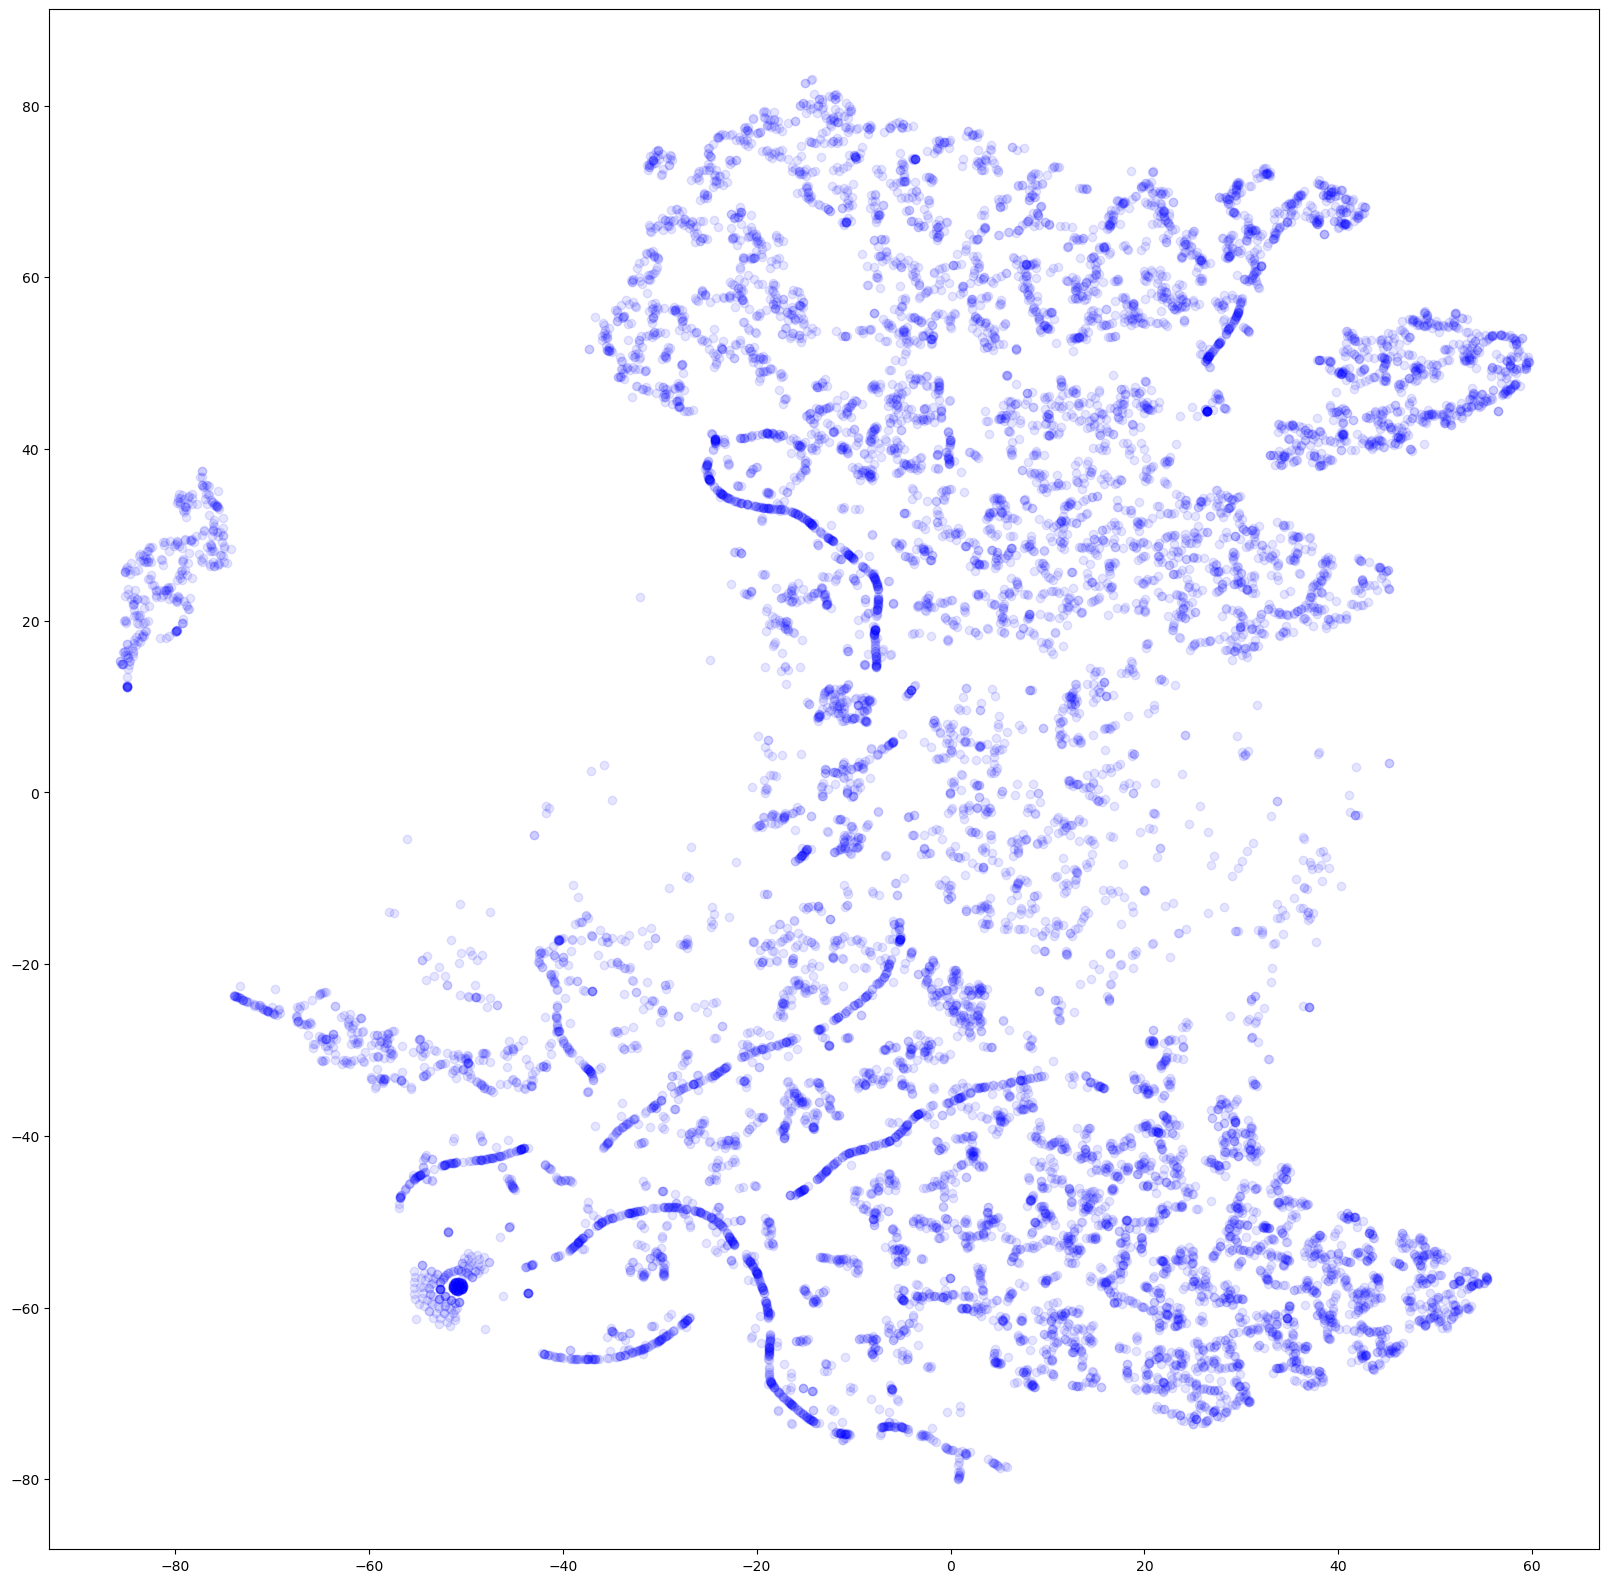

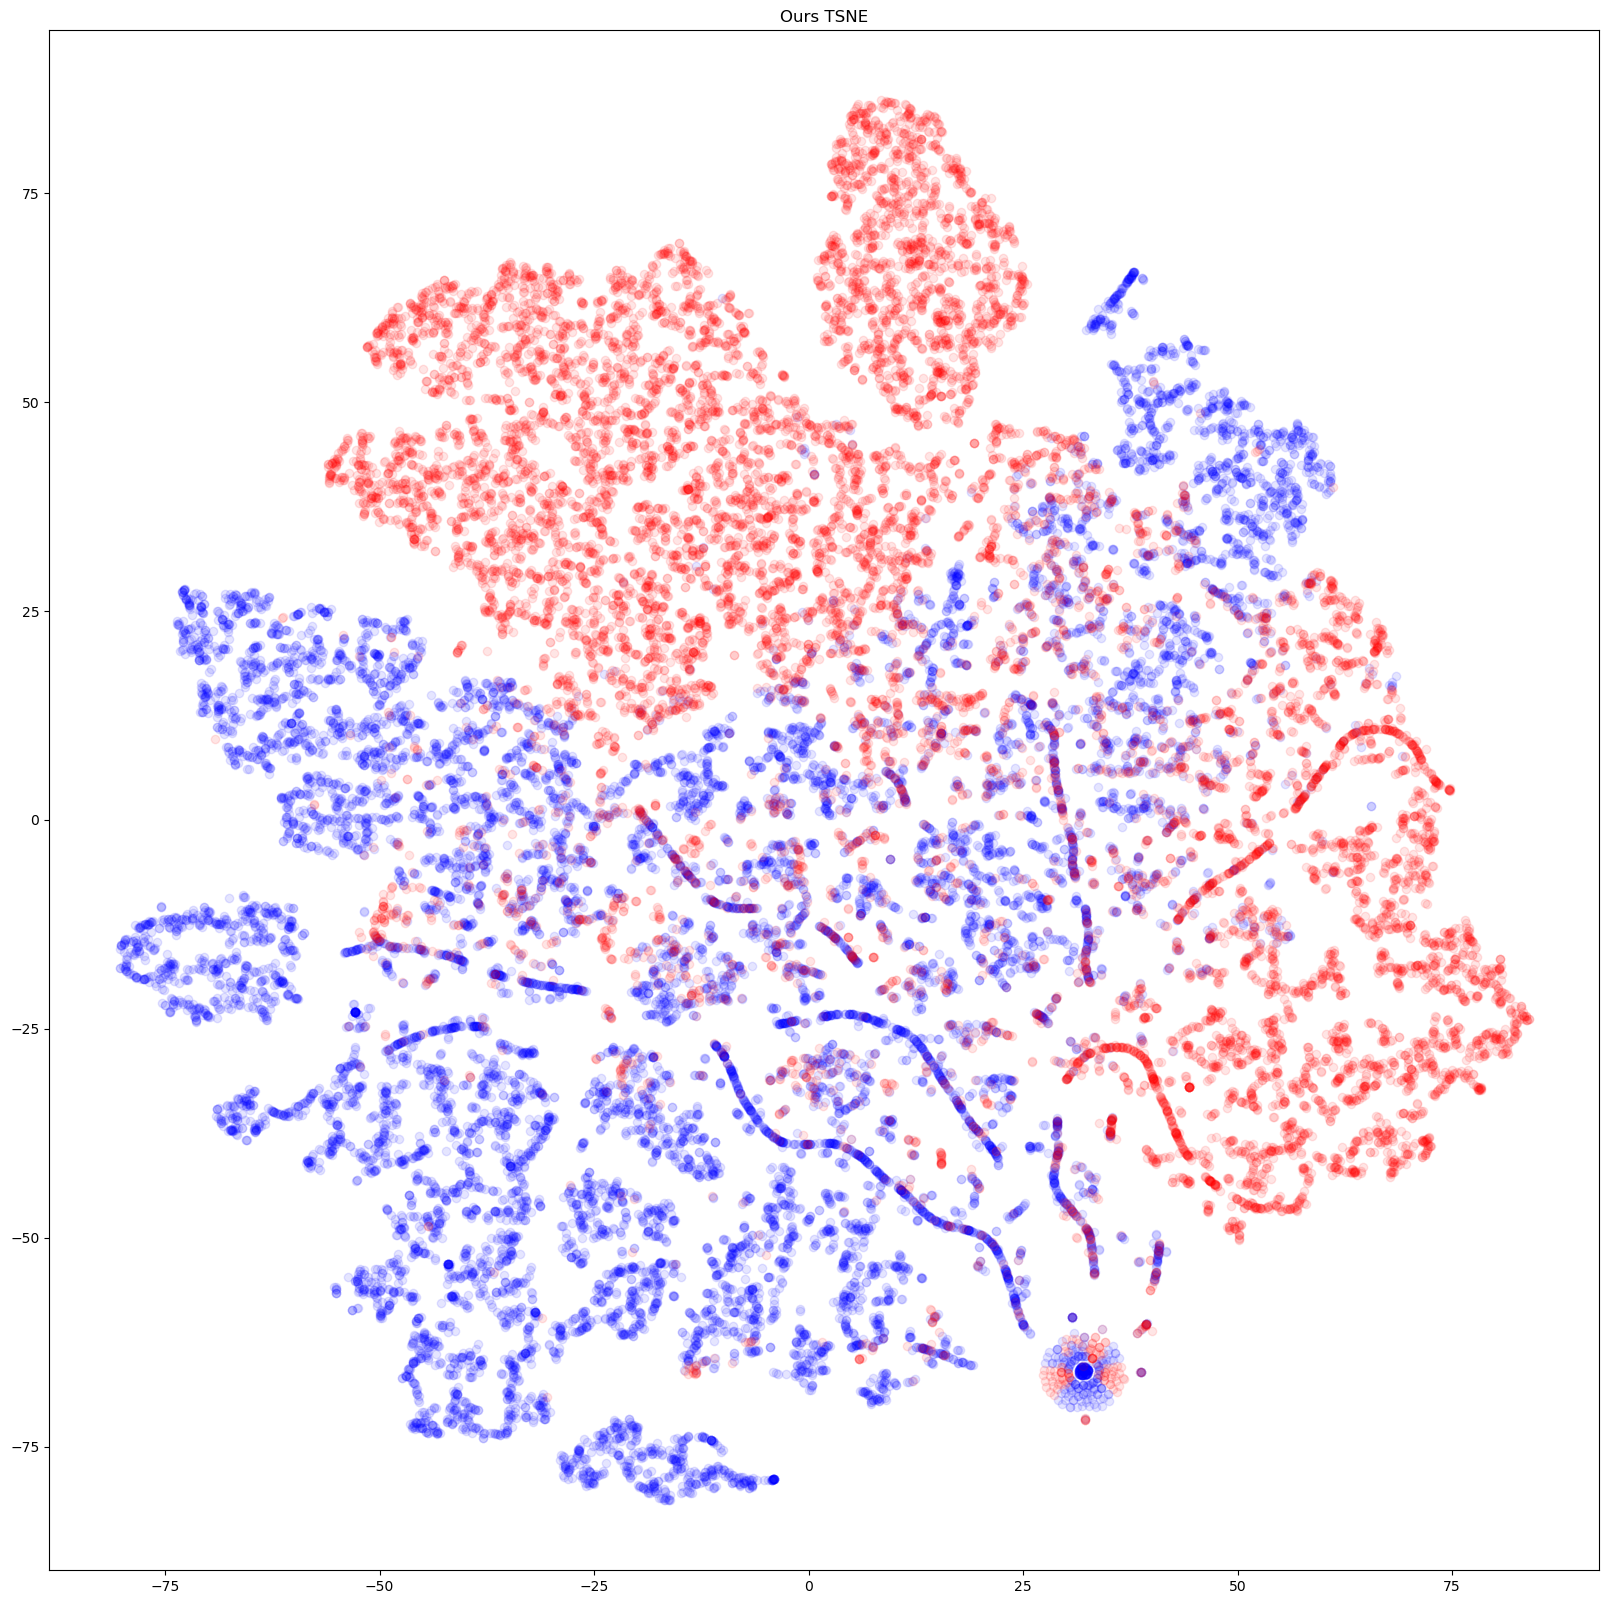

In [61]:
plt.figure(figsize=(20,20))
X_embedded = TSNE(n_components=2).fit_transform(vectors)
for x in range(0, len(X_embedded)):
    if x in range(0, len(clea)):
        plt.scatter(X_embedded[x][0],X_embedded[x][1], color='blue', alpha=0.1)
    else:
        plt.scatter(X_embedded[x][0],X_embedded[x][1], color='red', alpha=0.1)

plt.title('Ours TSNE')
plt.show()

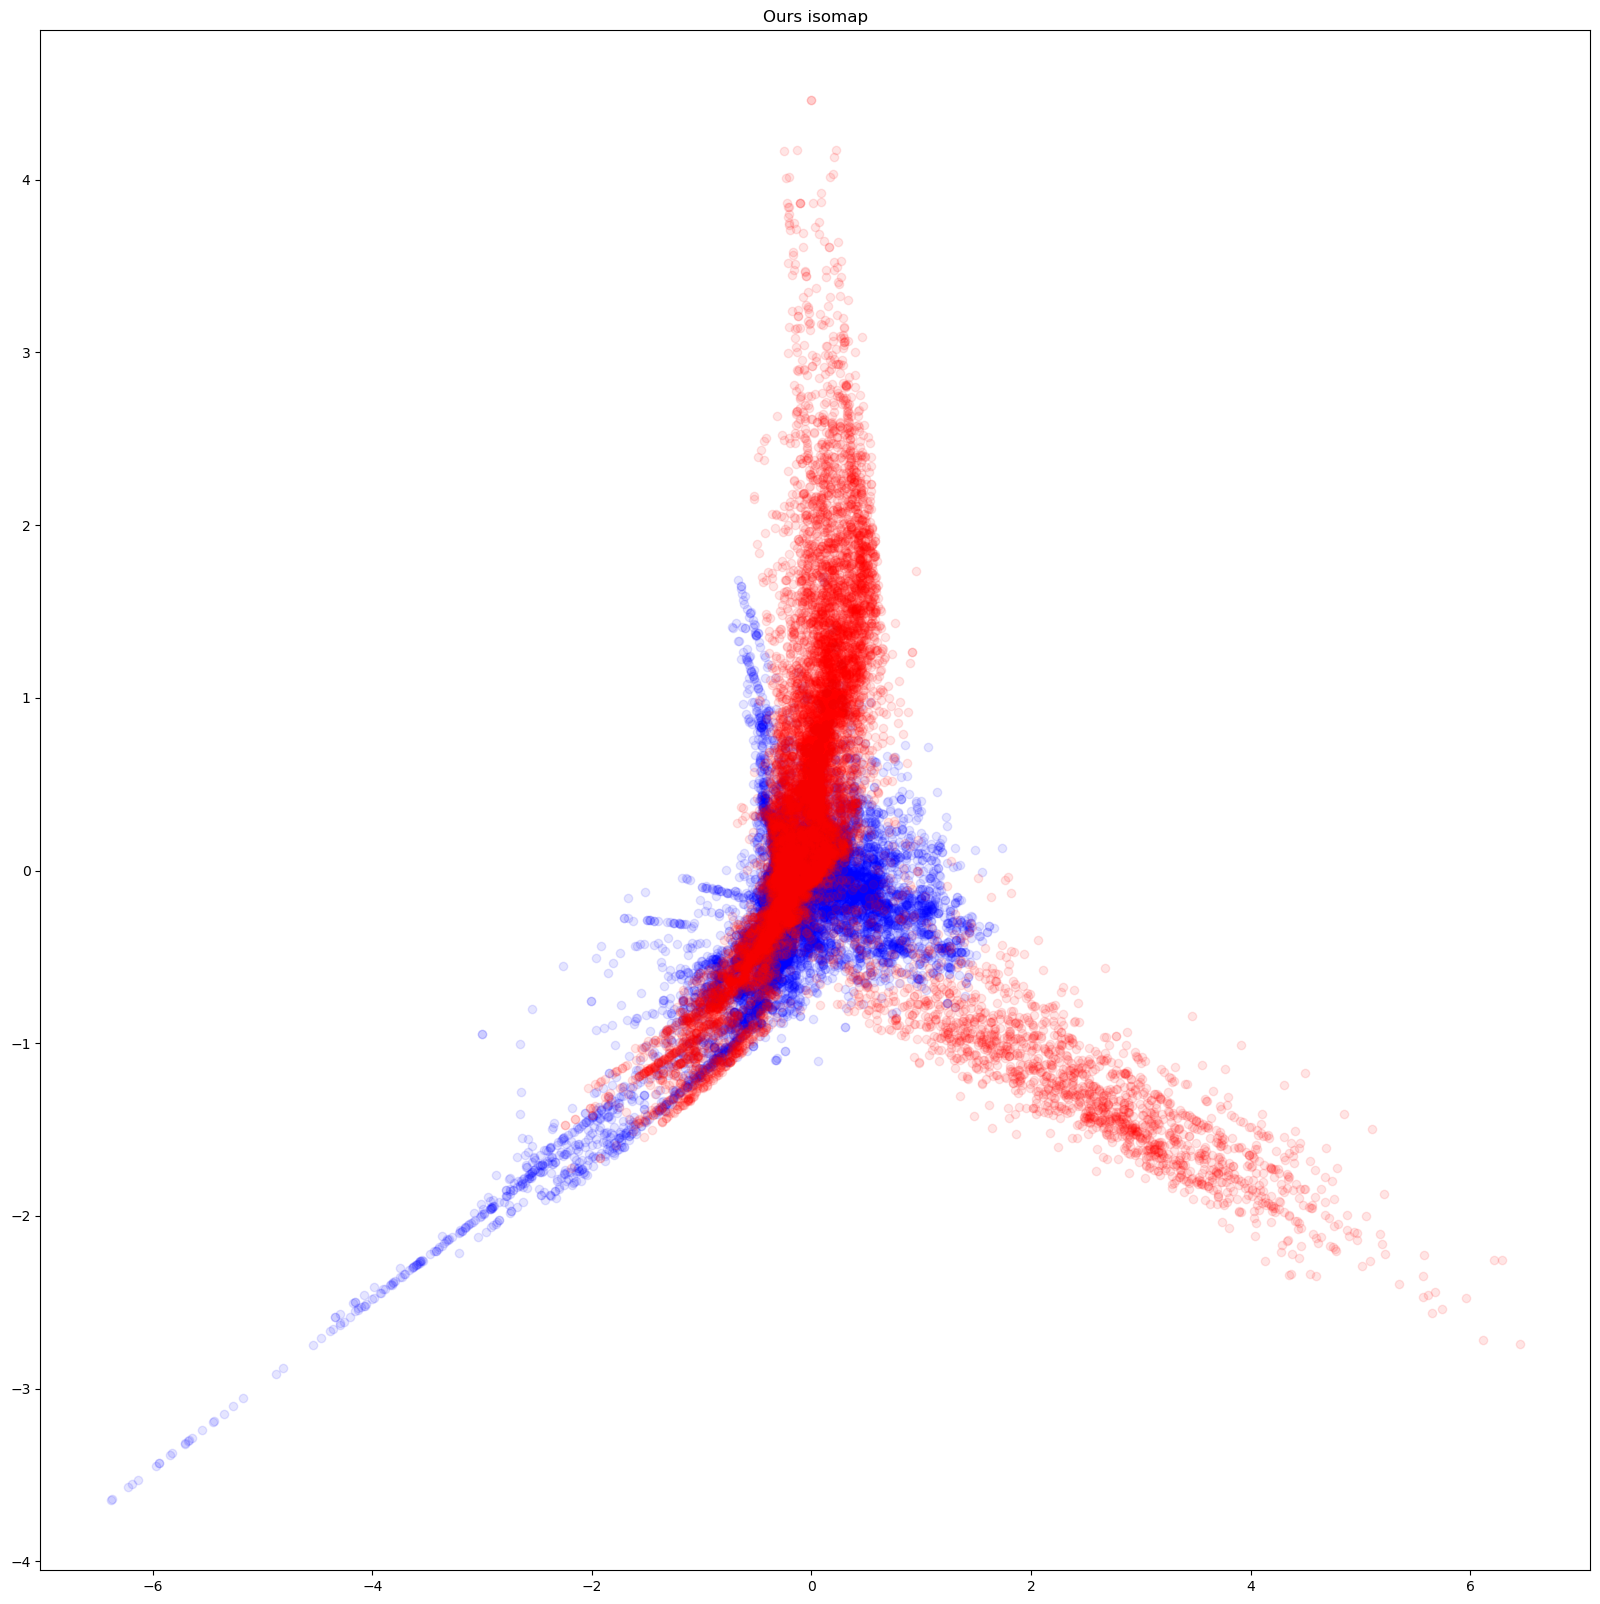

In [63]:
from sklearn.datasets import load_digits
from sklearn.manifold import Isomap
embedding = Isomap(n_components=2)

plt.figure(figsize=(20,20))
X_transformed = embedding.fit_transform(vectors)
for x in range(0, len(X_transformed)):
    if x in range(0, len(clea)):
        plt.scatter(X_transformed[x][0],X_transformed[x][1], color='blue', alpha=0.1)
    else:
        plt.scatter(X_transformed[x][0],X_transformed[x][1], color='red', alpha=0.1)

plt.title('Ours isomap')
plt.show()